### # Import thư viện cần thiết

In [14]:
import csv# thư viện để xử lí file .csv
import numpy as np # xử lí làm việc với file
import pandas as pd# thư viện làm việc với mảng số
import tensorflow as tf# thư viện cần để huấn luyện mô hình
import pickle# để đọc và sử lí file dạng pickle
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, LayerNormalization, Dropout,
    Bidirectional, LSTM, GlobalMaxPooling1D, Dense
)# đây là các layer trong mô hình
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer# thư viện để tokenize


### # Đọc lại dữ liệu từ các file đã được lưu trước đó trong bước Preprocessing

In [15]:
# Đọc tokenizer đã lưu
with open("tokenizer_data.pkl", "rb") as file:
    tokenizer_data = pickle.load(file)
# Tính lại data_voca_size từ tokenizer
data_voca_size = len(tokenizer_data.word_index) + 1
print("Loaded tokenizer and calculated data_voca_size:", data_voca_size)
# Đọc dữ liệu từ các file CSV
train_data = pd.read_csv("training_data_processed.csv")
val_data = pd.read_csv("val_data_processed.csv")
test_data = pd.read_csv("test_data_processed.csv")
# Tách feature và label
x_train = train_data.iloc[:, :-3].values  # Giả sử có 3 nhãn (one-hot encoding)
y_train = train_data.iloc[:, -3:].values
x_val = val_data.iloc[:, :-3].values
y_val = val_data.iloc[:, -3:].values
x_test = test_data.iloc[:, :-3].values
y_test = test_data.iloc[:, -3:].values
print("Loaded data:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


Loaded tokenizer and calculated data_voca_size: 11506
Loaded data:
x_train shape: (11306, 400)
y_train shape: (11306, 3)
x_val shape: (2423, 400)
y_val shape: (2423, 3)
x_test shape: (2423, 400)
y_test shape: (2423, 3)


### # Xây dựng mô hình cnn- kstm

In [16]:

def generate_model():# hàm chạy chính cho model kstm và cnn
    dropout_threshold =0.4
    input_dim =data_voca_size
    ouput_dim =32
    input_length = 400
    initializer= tf.keras.initializers.GlorotNormal()
    input_layer = Input(shape=(input_length,))
    feature =Embedding(input_dim=input_dim, output_dim=ouput_dim, embeddings_initializer="GlorotNormal")(input_layer)
    #CNN
    cnn_feature =Conv1D(filters=32, kernel_size=3, padding='same',activation='relu')(feature)
    cnn_feature =MaxPooling1D()(cnn_feature)
    cnn_feature =LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    #bidirectional kstm
    bi_sktm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
    bi_sktm_feature = MaxPooling1D()(bi_sktm_feature)
    bi_sktm_feature = LayerNormalization()(bi_sktm_feature)
    bi_sktm_feature = Dropout(dropout_threshold)(bi_sktm_feature)
    #COMBINE
    combine_feature =tf.keras.layers.Concatenate()([cnn_feature,bi_sktm_feature])
    combine_feature =GlobalMaxPooling1D()(combine_feature)
    combine_feature =LayerNormalization()(combine_feature)
    #combine_feature =Dropout(dropout_threshold)(combine_feature)
    # Dense Layers
    # phương hướng cải tiến có thể cho filter lên 64 và units lên 64 và cso thể thêm lớp attension để mà mô hình có thể trích xuất các đặc trưng quan trọng
    # mô hình hiện tại và ổn định là có lớp dense 90 và 30 ở dưới là thay đổi một chút, xí sang ny check lại nếu mà mô hình hoạt động không ổn định thì đổi lại, sau đó thêm drop out cho combine feature#
    classifier = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combine_feature)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model= tf.keras.Model(inputs = input_layer, outputs =classifier)
    return model
# mô hình trên đã giảm bỏ các bước
model =generate_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=1000,
    decay_rate=0.93
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer = Adam(learning_rate=lr_schedule),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 400, 32)   │    368,192 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 400, 32)   │      3,104 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 400, 64)   │     16,640 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 200, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 200, 64)   │          0 │ bidirectional_2[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 32)   │         64 │ max_pooling1d_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ max_pooling1d_5[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 200, 64)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 200, 96)   │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ concatenate_2[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      6,208 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        195 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 394,723 (1.51 MB)

 Trainable params: 394,723 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi giá trị val_loss
    patience=4,          # Số epoch không cải thiện trước khi dừng
    restore_best_weights=True,  # Khôi phục trọng số tốt nhất
    verbose=1
)
callback_model =tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss')
history =model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val),epochs=30, batch_size=32,callbacks=[callback_model,early_stopping])

Epoch 1/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.3770 - loss: 1.8936 - val_accuracy: 0.5968 - val_loss: 1.4866
Epoch 2/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.5815 - loss: 1.4496 - val_accuracy: 0.6471 - val_loss: 1.2149
Epoch 3/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.6951 - loss: 1.1441 - val_accuracy: 0.7123 - val_loss: 1.0284
Epoch 4/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.7657 - loss: 0.9192 - val_accuracy: 0.7388 - val_loss: 0.9301
Epoch 5/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.8155 - loss: 0.7612 - val_accuracy: 0.7144 - val_loss: 0.9387
Epoch 6/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 64s 181ms/step - accuracy: 0.8459 - loss: 0.6348 - val_accuracy: 0.7350 - val_loss: 0.8789
Epoch 7/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 78s 220ms/step - accuracy: 0.8713 - loss: 0.5337 - val_accuracy: 0.7383 - val_loss: 0.8817
Epoch 8/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.8850 - loss: 0

In [20]:
model.load_weights("model.keras")
model.evaluate(x_test,y_test)

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7205 - loss: 0.9906


[0.9361987709999084, 0.7325629591941833]

In [23]:
def preprocess_input(raw_input, tokenizer):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre =" ".join(input_text_pre)
    input_text_pre_accent= ViTokenizer.tokenize(input_text_pre)
    print("text preprocessed: ",input_text_pre_accent)
    tokenizer_data_text=tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen =400)
    return vec_data
def inference_model(input_feature,model):
    output=model(input_feature).numpy()[0]
    result =output.argmax()
    conf =float(output.max())
    label_dictionary={'negative':0,'neutral':1,'positive':2}
    label =list(label_dictionary.keys())
    return label[int(result)],conf
def prediction(raw_input, tokenizer,model):
    input_model=preprocess_input(raw_input,tokenizer_data)
    result,conf=inference_model(input_model,model)
    return result, conf
m_model= generate_model()
m_model=load_model('model.keras')
with open(r"tokenizer_data.pkl","rb")as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("nhưng được kể lại theo một góc nhìn mới mẻ và hiện đại hơn. Điểm sáng của phim nằm ở phần hình ảnh và kỹ xảo, với những cảnh quay đẹp mắt, trang phục được đầu tư kỹ lưỡng, tái hiện chân thực bối cảnh thời phong kiến. Diễn xuất của dàn diễn viên chính cũng khá ấn tượng, đặc biệt là cách họ thể hiện nội tâm của các nhân vật, từ sự lương thiện của Tấm đến âm mưu, toan tính của Cám. Tuy nhiên, cốt truyện đôi lúc bị kéo dài hoặc thay đổi so với nguyên bản, khiến một số người xem cảm thấy khó theo dõi hoặc không quen. Ngoài ra, phim còn gặp phải một số ý kiến trái chiều về việc cân bằng giữa yếu tố truyền thống và hiện đại, cũng như cách xử lý các tình tiết mang tính huyền bí. Nhìn chung, Cám là một nỗ lực đáng khen ngợi trong việc đưa văn hóa dân gian Việt Nam lên màn ảnh rộng, dù vẫn còn vài điểm có thể cải thiện. Đây là một bộ phim đáng xem, nhất là với những ai yêu thích các tác phẩm mang hơi thở cổ tích Việt Nam",my_tokenizer,m_model))

text preprocessed:  nhưng được kể lại theo một góc nhìn mới_mẻ và hiện_đại hơn điểm sáng của phim nằm ở phần hình_ảnh và kỹ_xảo với những cảnh quay đẹp_mắt trang_phục được đầu_tư kỹ_lưỡng tái_hiện chân_thực bối_cảnh thời phong_kiến diễn_xuất của dàn diễn_viên chính cũng khá ấn_tượng đặc_biệt là cách họ thể_hiện nội_tâm của các nhân_vật từ sự lương_thiện của tấm đến âm_mưu_toan_tính của cám tuy_nhiên cốt_truyện đôi lúc bị kéo_dài hoặc thay_đổi so với nguyên_bản khiến một_số người xem cảm_thấy khó theo_dõi hoặc không quen ngoài_ra phim còn gặp phải một_số ý_kiến trái chiều về việc cân_bằng giữa yếu_tố truyền_thống và hiện_đại cũng như cách xử_lý các tình_tiết mang tính huyền_bí nhìn_chung cám là một nỗ_lực đáng khen_ngợi trong việc đưa văn_hóa dân_gian việt nam lên màn_ảnh rộng dù vẫn còn vài điểm có_thể cải_thiện đây là một bộ phim đáng xem nhất_là với những ai yêu thích các tác_phẩm mang hơi thở cổ_tích việt_nam
('positive', 0.8702732920646667)


In [ ]:
#while(True):
 #   text=input()
   # if text =="end":
   #     break
   # else:
    #    print(prediction(text,my_tokenizer,m_model)[0]+"\n")

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


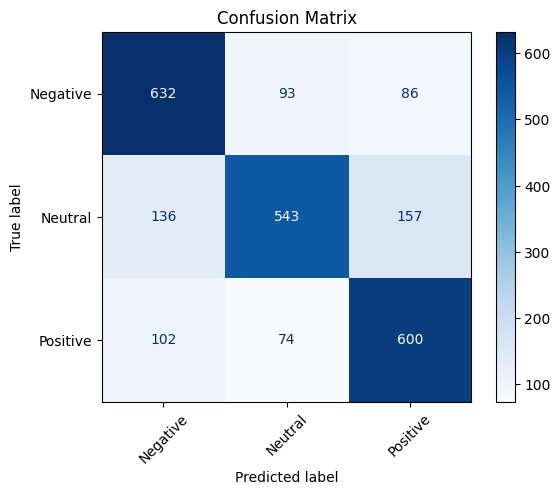

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hàm vẽ Confusion Matrix
def plot_confusion_matrix(model, X_test, y_test, class_names):

    # Dự đoán trên tập test
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Lấy nhãn dự đoán
    y_true = np.argmax(y_test, axis=1)  # Chuyển nhãn thực về integers (nếu one-hot)
    
    # Tính Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Hiển thị Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Ví dụ sử dụng
# Giả sử bạn đã có dữ liệu kiểm tra (X_test, y_test) và mô hình `model`
# class_names là danh sách tên các lớp, ví dụ: ["Negative", "Neutral", "Positive"]

plot_confusion_matrix(model, x_test, y_test, class_names=["Negative", "Neutral", "Positive"])


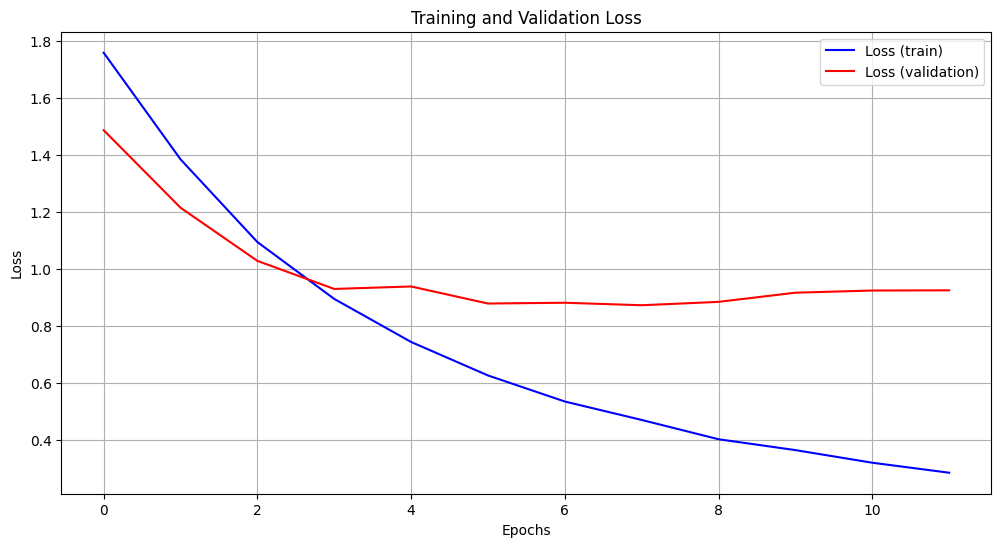

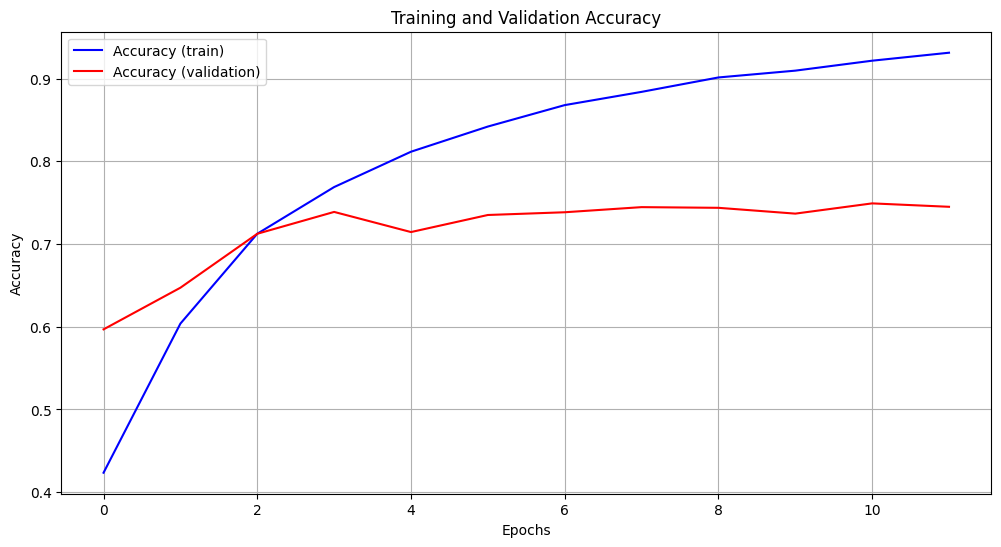

In [25]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss (train)', color='blue')
    plt.plot(history.history['val_loss'], label='Loss (validation)', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ đồ thị accuracy
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Accuracy (train)', color='blue')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation)', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sau khi huấn luyện mô hình, vẽ các đồ thị
plot_loss(history)
plot_accuracy(history)